# **Seattle Terry Stop Data Analysis**

##### Author: Spencer Hadel
***
### Overview

Recent tensions in the United States have led to a mistrust of police forces across the country, particularly due to the increasing strength of movements such as Black Lives Matter, and increased cultural attention to the racial and ethnic disparity in many facets of life. There is increasing focus on the scope of what police officer's are legally able to do, and whether they use this right fairly.

One such disparity has been observed in Terry Stops (also known as 'stop-and-frisks'), when a police officer uses theur right to legally temporarily detain a person based on 'reasonable suspsicion' that the person may be involved in criminal activity. The officer has the right to physically 'frisk' the subject, and take whatever action they feel is necessary properly handle the situation.

The newly elected mayor of Seattle campaigned on a platform of police reform, and has hired our agency to analyze, test, and interpret the current Seattle police department's Terry Stop data, so that their selected Chief of Police can make meaningful changes to the system as it stands.

***

# Part 1: Data Cleaning and Analysis

We will clean the dataset to create interpretable results, and then attempt to create classification models which can accurately predict Terry Stop outcomes based on Seattle's current record keeping standards. We will also investigate whether the data as it currently exists indicates any racial bias in the handling of Terry Stops.

In [1]:
from imports import *

In [2]:
# read data
data = pd.read_csv('data/Terry_Stops.csv')

#show data
data.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00.0000000,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00.0000000,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00.0000000,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00.0000000,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00.0000000,-,-,-,NaN,N,N,-,-,-


In [3]:
#look at data for dtypes and null values, cleaning

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52668 entries, 0 to 52667
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         52668 non-null  object
 1   Subject ID                52668 non-null  int64 
 2   GO / SC Num               52668 non-null  int64 
 3   Terry Stop ID             52668 non-null  int64 
 4   Stop Resolution           52668 non-null  object
 5   Weapon Type               52668 non-null  object
 6   Officer ID                52668 non-null  object
 7   Officer YOB               52668 non-null  int64 
 8   Officer Gender            52668 non-null  object
 9   Officer Race              52668 non-null  object
 10  Subject Perceived Race    52668 non-null  object
 11  Subject Perceived Gender  52668 non-null  object
 12  Reported Date             52668 non-null  object
 13  Reported Time             52668 non-null  object
 14  Initial Call Type     

All columns seem to match up except for one, shown more clearly below

In [4]:
data.isnull().sum()

Subject Age Group             0
Subject ID                    0
GO / SC Num                   0
Terry Stop ID                 0
Stop Resolution               0
Weapon Type                   0
Officer ID                    0
Officer YOB                   0
Officer Gender                0
Officer Race                  0
Subject Perceived Race        0
Subject Perceived Gender      0
Reported Date                 0
Reported Time                 0
Initial Call Type             0
Final Call Type               0
Call Type                     0
Officer Squad               486
Arrest Flag                   0
Frisk Flag                    0
Precinct                      0
Sector                        0
Beat                          0
dtype: int64

In [5]:
#officer squad has null values
data['Officer Squad'].value_counts()

TRAINING - FIELD TRAINING SQUAD                        5594
WEST PCT 1ST W - DAVID/MARY                            1671
SOUTHWEST PCT 2ND W - FRANK                            1142
WEST PCT 2ND W - D/M RELIEF                            1113
WEST PCT 1ST W - KING/QUEEN                            1030
                                                       ... 
TRAF - MOTORCYCLE UNIT - T3 SQUAD                         1
COMMUNITY OUTREACH - YOUTH VIOLENCE -SCHOOLS DETAIL       1
SVU SQUAD D - ORDER SERVICE                               1
COMM - INTERNET AND TELEPHONE REPORTING (ITRU)            1
DV SQUAD D - ORDER SERVICE                                1
Name: Officer Squad, Length: 184, dtype: int64

In [6]:
#this data not relevant to current objective

data_nulls_removed = data.drop(['Officer Squad'], axis=1)

#now check other columns for things to drop

## Investigating the Data

The page on data.seattle.gov lists descriptions for each column as the following:

> * `Subject Age Group`: Subject Age Group (10 year increments) as reported by the officer.
> * `Subject ID`: Key, generated daily, identifying unique subjects in the dataset using a character to character match of first name and last name. "Null" values indicate an "anonymous" or "unidentified" subject. Subjects of a Terry Stop are not required to present identification.
> * `GO / SC Num`: General Offense or Street Check number, relating the Terry Stop to the parent report. This field may have a one to many relationship in the data.
> * `Terry Stop ID`: Key identifying unique Terry Stop reports.
> * `Stop Resolution`: Resolution of the stop as reported by the officer.
> * `Weapon Type`: Type of weapon, if any, identified during a search or frisk of the subject. Indicates "None" if no weapons was found.
> * `Officer ID`: Key identifying unique officers in the dataset.
> * `Officer YOB`: Year of birth, as reported by the officer.
> * `Officer Gender`: Gender of the officer, as reported by the officer.
> * `Officer Race`: Race of the officer, as reported by the officer.
> * `Subject Perceived Race`: Perceived race of the subject, as reported by the officer.
> * `Subject Perceived Gender`: Perceived gender of the subject, as reported by the officer.
> * `Reported Date`: Date the report was filed in the Records Management System (RMS). Not necessarily the date the stop occurred but generally within 1 day.
> * `Reported Time`: Time the stop was reported in the Records Management System (RMS). Not the time the stop occurred but generally within 10 hours.
> * `Initial Call Type`: Initial classification of the call as assigned by 911.
> * `Final Call Type`: Final classification of the call as assigned by the primary officer closing the event.
> * `Call Type`: How the call was received by the communication center.
> * `Officer Squad`: Functional squad assignment (not budget) of the officer as reported by the Data Analytics Platform (DAP).
> * `Arrest Flag`: Indicator of whether a "physical arrest" was made, of the subject, during the Terry Stop. Does not necessarily reflect a report of an arrest in the Records Management System (RMS).
> * `Frisk Flag`: Indicator of whether a "frisk" was conducted, by the officer, of the subject, during the Terry Stop.
> * `Precinct`: Precinct of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.
> * `Sector`: Sector of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.
> * `Beat`: Beat of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.

Reported Time does not apply to this study, and Reported Date will be used with Officer YOB to create a new column, the approximate Officer Age.

ID numbers arent useful for creating a data model.

Likewise, the Precinct, Sector, and Beat information are not significant to this study. Future examinations could of course use this data to examine how individual precincts or sectors engage in racial or gender bias in Terry Stops.

In [7]:
#create new column 'officer age'
data_nulls_removed['Officer_Age'] = data_nulls_removed['Reported Date'].str[:4].astype(int)-data_nulls_removed['Officer YOB']

drop_list = ['Reported Date', 'Officer YOB','Subject ID', 'Terry Stop ID', 'Officer ID',  'GO / SC Num', 'Precinct', 'Sector', 
             'Beat', 'Reported Time']

df = data_nulls_removed.drop(drop_list, axis=1)

In [8]:
#replace spaces in column names with underscores
df.columns = df.columns.str.replace(' ','_')
df.head()

,Subject_Age_Group,Stop_Resolution,Weapon_Type,Officer_Gender,Officer_Race,Subject_Perceived_Race,Subject_Perceived_Gender,Initial_Call_Type,Final_Call_Type,Call_Type,Arrest_Flag,Frisk_Flag,Officer_Age
0,-,Arrest,None,M,Black or African American,Asian,Male,-,-,-,N,N,31
1,-,Field Contact,None,M,White,-,-,-,-,-,N,N,50
2,-,Field Contact,None,M,White,White,Male,-,-,-,N,-,54
3,-,Field Contact,None,M,White,-,-,-,-,-,N,N,52
4,-,Field Contact,None,M,White,Black or African American,Male,-,-,-,N,N,38


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52668 entries, 0 to 52667
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject_Age_Group         52668 non-null  object
 1   Stop_Resolution           52668 non-null  object
 2   Weapon_Type               52668 non-null  object
 3   Officer_Gender            52668 non-null  object
 4   Officer_Race              52668 non-null  object
 5   Subject_Perceived_Race    52668 non-null  object
 6   Subject_Perceived_Gender  52668 non-null  object
 7   Initial_Call_Type         52668 non-null  object
 8   Final_Call_Type           52668 non-null  object
 9   Call_Type                 52668 non-null  object
 10  Arrest_Flag               52668 non-null  object
 11  Frisk_Flag                52668 non-null  object
 12  Officer_Age               52668 non-null  int64 
dtypes: int64(1), object(12)
memory usage: 5.2+ MB


We now observe what sort of data is in the columns that remain.

In [10]:
df['Subject_Age_Group'].value_counts().sort_index(ascending=True)

-                1786
1 - 17           2067
18 - 25         10360
26 - 35         17599
36 - 45         11375
46 - 55          6765
56 and Above     2716
Name: Subject_Age_Group, dtype: int64

In [11]:
df['Arrest_Flag'].value_counts()

N    47932
Y     4736
Name: Arrest_Flag, dtype: int64

In [12]:
df['Stop_Resolution'].value_counts()

Field Contact               22308
Offense Report              16499
Arrest                      12944
Referred for Prosecution      728
Citation / Infraction         189
Name: Stop_Resolution, dtype: int64

This column is interesting, as first of all the "Arrest" values do not line up with the "Arrest Flag" column. The description of this data says that "Arrest Flag" applies to whether or not a "physical arrest" was made AT the stop. We will break this collective data into multiple new columns. Each of these new columns will be target variables for different runs of our classifiers in the future.

"Arrest Flag" will change to "Physical Arrest", and "Stop Resolution" will be changed to "Legal Action Taken" for all cases that do not list "Field Contact" as their value (which we can assume is simply the act of an officer performing the stop). Additionally, we will create a new column specifically for when the resolution was officially an arrest, and name it "Arrested".

In [13]:
#organize data into new columns

df['Legal_Action_Taken'] = df['Stop_Resolution'].map(lambda x: 0 if x in ['Field Contact'] else 1)
df['Arrested'] = df['Stop_Resolution'].map(lambda x: 1 if x == 'Arrest' else 0)
df['Physical_Arrest'] = df['Arrest_Flag'].map(lambda x: 1 if x == 'Y' else 0)

df.drop(['Stop_Resolution', 'Arrest_Flag'], axis=1, inplace=True)

In [14]:
for x in ['Arrested', 'Legal_Action_Taken', 'Physical_Arrest']:
    print(df[x].value_counts())

0    39724
1    12944
Name: Arrested, dtype: int64
1    30360
0    22308
Name: Legal_Action_Taken, dtype: int64
0    47932
1     4736
Name: Physical_Arrest, dtype: int64


In [15]:
df['Weapon_Type'].value_counts()

None                                    32565
-                                       16892
Lethal Cutting Instrument                1482
Knife/Cutting/Stabbing Instrument         917
Handgun                                   333
Blunt Object/Striking Implement           118
Firearm Other                             100
Firearm                                    59
Club, Blackjack, Brass Knuckles            49
Mace/Pepper Spray                          41
Other Firearm                              38
Firearm (unk type)                         15
Taser/Stun Gun                             12
Fire/Incendiary Device                     11
Club                                        9
None/Not Applicable                         9
Rifle                                       8
Shotgun                                     4
Personal Weapons (hands, feet, etc.)        2
Automatic Handgun                           2
Blackjack                                   1
Brass Knuckles                    

For the sake of clarity, we will separate weapon data into whether or not a weapon was reported. The specific type of weapon is not significant to our analysis.

In [16]:
#separate weapon type data

df.rename(columns={"Weapon_Type": "Was_Weapon_Reported"}, inplace=True)

unarmed = ['None', '-', 'None/Not Applicable','Personal Weapons (hands, feet, etc.)']

df['Was_Weapon_Reported'] = df['Was_Weapon_Reported'].map(lambda x: 'No Weapon Reported' if x in unarmed else 'Weapon Reported')

df['Was_Weapon_Reported'].value_counts()

No Weapon Reported    49468
Weapon Reported        3200
Name: Was_Weapon_Reported, dtype: int64

In [17]:
df['Officer_Gender'].value_counts()

M    46629
F     6009
N       30
Name: Officer_Gender, dtype: int64

In [18]:
df['Officer_Race'].value_counts()

White                            38737
Two or More Races                 3232
Hispanic or Latino                3196
Asian                             2332
Not Specified                     2210
Black or African American         2102
Nat Hawaiian/Oth Pac Islander      484
American Indian/Alaska Native      332
Unknown                             43
Name: Officer_Race, dtype: int64

In [19]:
df['Subject_Perceived_Race'].value_counts()

White                                        25798
Black or African American                    15666
Unknown                                       3407
-                                             1809
Asian                                         1764
Hispanic                                      1684
American Indian or Alaska Native              1487
Multi-Racial                                   809
Other                                          152
Native Hawaiian or Other Pacific Islander       92
Name: Subject_Perceived_Race, dtype: int64

We will combine 'Unknown', 'Other', and '-' into one variable, and for the purposes of this analysis they will all become 'Unknown'.

In [20]:
df['Subject_Perceived_Race'].replace(['Other','-'],'Unknown', inplace=True)
df['Subject_Perceived_Race'].value_counts()

White                                        25798
Black or African American                    15666
Unknown                                       5368
Asian                                         1764
Hispanic                                      1684
American Indian or Alaska Native              1487
Multi-Racial                                   809
Native Hawaiian or Other Pacific Islander       92
Name: Subject_Perceived_Race, dtype: int64

In [21]:
df['Subject_Perceived_Gender'].value_counts()

Male                                                         41442
Female                                                       10581
Unable to Determine                                            326
-                                                              238
Unknown                                                         63
Gender Diverse (gender non-conforming and/or transgender)       18
Name: Subject_Perceived_Gender, dtype: int64

For the sake of this analysis, we will group together all perceived Genders that do not fall under the category of Male or Female into one value, using "N" to match the existing Officer Gender Data.

In [22]:
n_gender = ['-', 'Unknown', 'Gender Diverse (gender non-conforming and/or transgender)', 'Unable to Determine']
df['Subject_Perceived_Gender'].replace(n_gender, 'N' , inplace=True)

df.replace({'Subject_Perceived_Gender' : { 'Male' : 'M', 'Female' : 'F'}}, inplace=True)

df['Subject_Perceived_Gender'].value_counts()

M    41442
F    10581
N      645
Name: Subject_Perceived_Gender, dtype: int64

In [23]:
pd.set_option("display.max_rows", None)
df['Initial_Call_Type'].value_counts()

-                                                     13484
SUSPICIOUS STOP - OFFICER INITIATED ONVIEW             3684
SUSPICIOUS PERSON, VEHICLE OR INCIDENT                 3505
DISTURBANCE, MISCELLANEOUS/OTHER                       2680
ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS)         2306
TRESPASS                                               2110
SHOPLIFT - THEFT                                       1598
THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS)              1563
FIGHT - IP - PHYSICAL (NO WEAPONS)                     1423
WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/DIST)         1267
ROBBERY - IP/JO (INCLUDES STRONG ARM)                  1007
BURG - IP/JO - RES (INCL UNOCC STRUCTURES)              983
THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING)           895
AUTO RECOVERY                                           865
NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)        856
DIST - IP/JO - DV DIST - NO ASLT                        777
TRAFFIC STOP - OFFICER INITIATED ONVIEW 

In [24]:
df['Final_Call_Type'].value_counts()

-                                                     13484
--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON               4462
--PROWLER - TRESPASS                                   3639
--DISTURBANCE - OTHER                                  3000
--ASSAULTS, OTHER                                      2547
--WARRANT SERVICES - FELONY                            1816
--THEFT - SHOPLIFT                                     1440
--DV - ARGUMENTS, DISTURBANCE (NO ARREST)              1432
--DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY)           1326
--ASSAULTS - HARASSMENT, THREATS                       1195
--SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE              1180
--WARRANT SERVICES - MISDEMEANOR                       1096
--NARCOTICS - OTHER                                    1071
--CRISIS COMPLAINT - GENERAL                            991
--THEFT - ALL OTHER                                     886
--PROPERTY DEST (DAMG)                                  824
--BURGLARY - NON RESIDENTIAL/COMMERCIAL 

In [25]:
df['Call_Type'].value_counts()

911                              24282
-                                13484
ONVIEW                           10806
TELEPHONE OTHER, NOT 911          3646
ALARM CALL (NOT POLICE ALARM)      434
TEXT MESSAGE                        15
SCHEDULED EVENT (RECURRING)          1
Name: Call_Type, dtype: int64

The various 'Call Type' columns yield a very large variety of data. For the current purposes of this analysis, there is too miuch variability and too much potential for negatively impacting out algorithms (certain 'Final Call Type's specifying whether or not an arrest was made could present redundant data since there is also a column of arrest flags, for example.) 

While it is outside the scope of the current analysis, this information could nonetheless be valuable for more in depth studies of Terry Stop Data conducted as a continuation of this one. For the time being, these columns will be dropped.

In [26]:
#remove call type data
drop_call_types = ['Call_Type', 'Initial_Call_Type', 'Final_Call_Type']

df.drop(drop_call_types, axis=1, inplace=True)

In [27]:
df['Frisk_Flag'].value_counts()

N    40062
Y    12128
-      478
Name: Frisk_Flag, dtype: int64

We could interpret '-' as a non-Frisk, but there is just as much likelihood that the '-' refers to an unreported Frisk. Because there are so few entries with this information, our 52,000 remaining entries will not be harmed by the removal of this data to be safe.

In [28]:
df = df[df['Frisk_Flag'] != '-']
df.replace({'Frisk_Flag' : { 'Y' : 1, 'N' : 0}}, inplace=True)
df['Frisk_Flag'].value_counts()

0    40062
1    12128
Name: Frisk_Flag, dtype: int64

In [29]:
df['Officer_Age'].value_counts().sort_index(ascending=True)

21       19
22      262
23      981
24     1909
25     2231
26     2636
27     2553
28     2863
29     3014
30     3173
31     3363
32     3084
33     3038
34     2823
35     2255
36     1632
37     1466
38     1324
39     1148
40     1152
41      971
42     1079
43      791
44      827
45      841
46      886
47      671
48      689
49      630
50      590
51      479
52      421
53      419
54      478
55      368
56      274
57      261
58      204
59      101
60       86
61       48
62       18
63       35
64       15
65       16
66        2
67       12
68        6
69        2
70        1
115       1
116       2
117       1
118       3
119      28
121       8
Name: Officer_Age, dtype: int64

It's unlikely that there are officers over 100 years old making this arrests, and very few entries contain this odd data, so we will remove them.

In [30]:
df = df[df['Officer_Age']<100]
df['Officer_Age'].value_counts().sort_index(ascending=True)

21      19
22     262
23     981
24    1909
25    2231
26    2636
27    2553
28    2863
29    3014
30    3173
31    3363
32    3084
33    3038
34    2823
35    2255
36    1632
37    1466
38    1324
39    1148
40    1152
41     971
42    1079
43     791
44     827
45     841
46     886
47     671
48     689
49     630
50     590
51     479
52     421
53     419
54     478
55     368
56     274
57     261
58     204
59     101
60      86
61      48
62      18
63      35
64      15
65      16
66       2
67      12
68       6
69       2
70       1
Name: Officer_Age, dtype: int64

In [31]:
#safe new data1
df.to_csv('./data/cleaned_df.csv', index=False)


## Visualizations of Data

This data is ready to be preprocessed and run through various classifiers to attempt to predict outcomes based on the features and targets we have just cleaned. This will happen in the [Data Modeling Notebook](./nb_2-terry_models.ipynb)

Before we do this, however, we will now visualize the cleaned data in relation to our objectives, in an investigation of the racial disparity in Terry Stops.

In [218]:
#create new dataframe organizing info by race

viz1_df = df[['Subject_Perceived_Race','Legal_Action_Taken', 'Arrested']]
viz1_df = viz1_df.set_index('Subject_Perceived_Race').groupby('Subject_Perceived_Race').sum()
viz1_df['Stopped'] = df.groupby('Subject_Perceived_Race').count()['Arrested']

first_column = viz1_df.pop('Stopped') 
viz1_df.insert(0, 'Stopped', first_column)

viz1_df.sort_values(by='Stopped', ascending=False, inplace=True)
viz1_df.head()

,Stopped,Legal_Action_Taken,Arrested
Subject_Perceived_Race,,,
White,25565,14491,6072
Black or African American,15538,9694,4324
Unknown,5269,2395,946
Asian,1752,1005,478
Hispanic,1666,1059,399


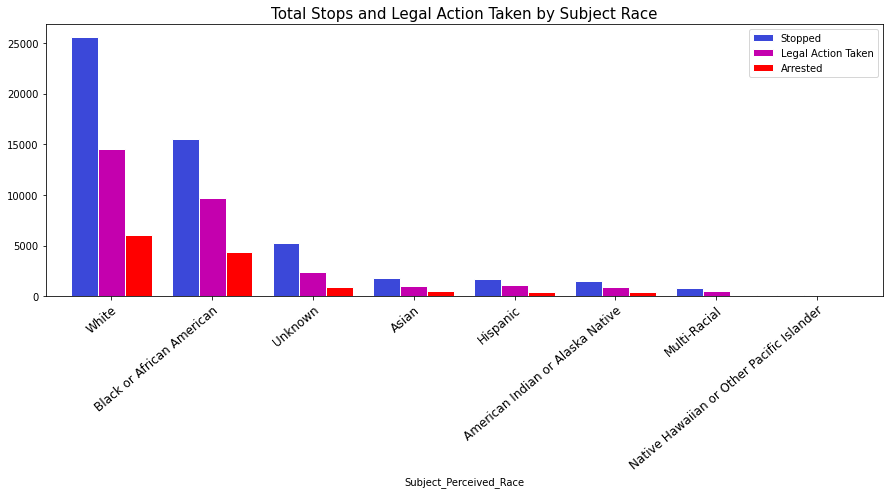

In [232]:
colors={'Stopped':'#3b48d9', 'Legal_Action_Taken':'#c400ae', 'Arrested':'#ff0000'}

viz1_df.plot(kind='bar', figsize=(15,5), legend=True, edgecolor='white', width=0.8,
             color=colors)
plt.xticks(rotation= 40, ha='right', rotation_mode='anchor', fontsize=12)
plt.title('Total Stops and Legal Action Taken by Subject Race', fontsize=15)
plt.legend(['Stopped', 'Legal Action Taken', 'Arrested'])

plt.savefig('./img/stop_outcome_by_race')

On the surface this data doesn't seem to tell us much. We see a consistent trend of results that are hard to draw any real meaning from. Before we discount these, though, we will investigate demographics of Seattle's population.

In [220]:
demo_data = pd.read_csv('data/demographics.csv')
print("Demographic Data on the population of Seattle as of 2022:")
demo_data

Demographic Data on the population of Seattle as of 2022:


,Race,Population,Percentage
0,White,487824,0.6581
1,Asian,120921,0.1631
2,Two or More Races,56632,0.0764
3,Black or African American,52334,0.0706
4,Some Other Race,17629,0.0238
5,American Indian and Alaska Native,3972,0.0054
6,Native Hawaiian and Other Pacific Islander,1939,0.0026


This data shows that the white population of Seattle makes up 65% of the population. And the Black population makes up 7% of the popoulation. Nonetheless, there seems to be an almost equal amount of stops, frisks, and arrests for both racial backgrounds.


In [227]:
#adjust race names to match
demo_data['Race'].replace('Two or More Races', 'Multi-Racial' , inplace=True)
demo_data['Race'].replace('Some Other Race', 'Unknown' , inplace=True)

#join data


race_df = df.groupby(['Subject_Perceived_Race']).sum()

race_df = demo_data.join(race_df, on='Race')

race_df = race_df.fillna(0)

#rename lower population numbers to combined "Other"
lower_pop = ['Unknown', 'American Indian and Alaska Native', 'Native Hawaiian and Other Pacific Islander']
total = race_df[race_df['Race'].isin(lower_pop)].sum()
total.name = 'Other'
total['Race']='Other'

# Assign sum of all rows of DataFrame as a new Row
race_df = race_df.append(total.transpose())
race_df = race_df[~race_df['Race'].isin(lower_pop)]
# race_df


#totals column
total_stops = df.groupby(['Subject_Perceived_Race'], as_index=False).count()[['Subject_Perceived_Race','Arrested']]
total_stops.rename(columns={'Arrested': 'Total_Stopped', 'Subject_Perceived_Race':'Race'}, inplace=True)

lower_pop = ['Unknown', 'American Indian or Alaska Native', 'Native Hawaiian or Other Pacific Islander']

total = total_stops[total_stops['Race'].isin(lower_pop)].sum()
total.name = 'Other'
total['Race']='Other'
total_stops = total_stops.append(total.transpose())
total_stops = total_stops[~total_stops['Race'].isin(lower_pop)]

# total_stops
race_df = total_stops.merge(race_df, on='Race', how='inner')

race_df['no_legal_action'] = race_df['Total_Stopped']-race_df['Legal_Action_Taken']

race_df

,Race,Total_Stopped,Population,Percentage,Frisk_Flag,Officer_Age,Legal_Action_Taken,Arrested,Physical_Arrest,no_legal_action
0,Asian,1752,120921,0.1631,478.0,59656.0,1005.0,478.0,200.0,747.0
1,Black or African American,15538,52334,0.0706,4260.0,529157.0,9694.0,4324.0,1627.0,5844.0
2,Multi-Racial,796,56632,0.0764,181.0,29653.0,496.0,159.0,0.0,300.0
3,White,25565,487824,0.6581,5112.0,890007.0,14491.0,6072.0,2277.0,11074.0
4,Other,6830,23540,0.0318,1288.0,179801.0,2395.0,946.0,475.0,4435.0


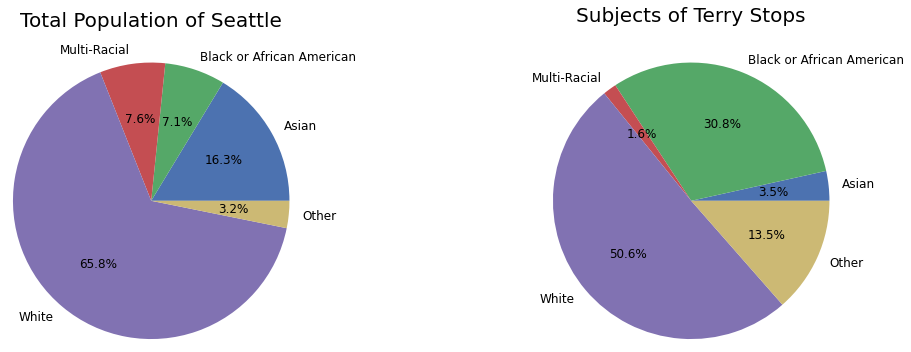

In [228]:
labels = ['Asian', 'Black or African American', 'Multi-Racial', 'White', 'Other']

fig = plt.figure(figsize=(15,8))

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(race_df['Population'], labels=labels, radius = 1.2, textprops={'fontsize': 12}, autopct='%.1f%%')
ax1.set_title('Total Population of Seattle', fontsize=20, pad=30)


ax2 = fig.add_axes([.5, .0, .5, .5], aspect=1)
ax2.pie(race_df['Total_Stopped'], labels=labels, radius = 1.2, textprops={'fontsize': 12}, autopct='%.1f%%')
ax2.set_title('Subjects of Terry Stops', fontsize=20,  pad=35)



plt.show()

To simplify, lets look at total populations vs total stops:

In [237]:
race_df.set_index('Race', inplace=True)

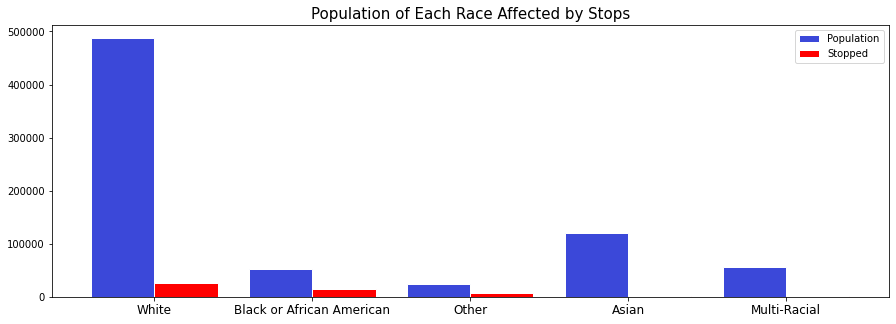

In [238]:
colors={'Population':'#3b48d9', 'Total_Stopped':'#ff0000'}

viz_race = race_df[['Population', 'Total_Stopped']].sort_values(by='Total_Stopped', ascending=False)
viz_race.plot(kind='bar', figsize=(15,5), legend=True, edgecolor='white', width=0.8,
            title='Population Vs Total Stops', color=colors)
plt.xticks(rotation= 0, fontsize=12)
plt.xlabel('')
plt.title('Population of Each Race Affected by Stops', fontsize=15)
plt.legend(['Population', 'Stopped'])


plt.savefig('./img/pop_vs_stops_etc')

Now we look at what percentage **of each** group in Seattle faces Terry Stops and their various outcomes:

In [239]:
viz_race_2 = pd.DataFrame()
viz_race_2['Percent_Stopped'] = race_df['Total_Stopped']/race_df['Population']
viz_race_2['Legal_Action_Taken'] = race_df['Legal_Action_Taken']/race_df['Population']
viz_race_2['Arrested'] = race_df['Arrested']/race_df['Population']
viz_race_2.sort_values(by='Percent_Stopped', ascending=False, inplace=True)
#viz_race_2

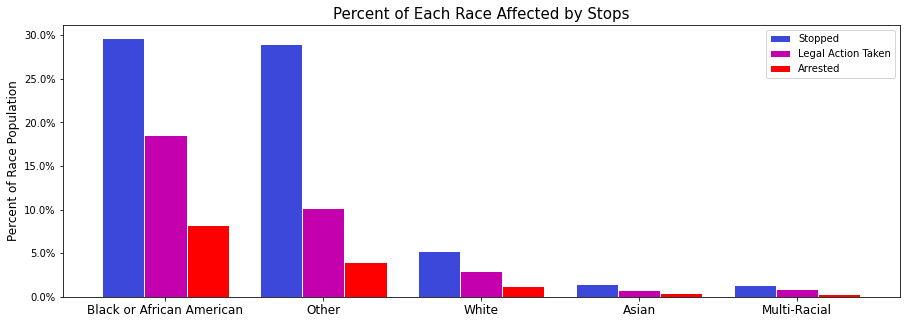

In [240]:
import matplotlib.ticker as mtick

colors={'Percent_Stopped':'#3b48d9', 'Legal_Action_Taken':'#c400ae', 'Arrested':'#ff0000'}

viz_race_2.plot(kind='bar', figsize=(15,5), legend=True, edgecolor='white', width=0.8, color=colors)

plt.xticks(rotation= 0, fontsize=12)
plt.xlabel('')
plt.ylabel('Percent of Race Population', fontsize=12)
plt.title('Percent of Each Race Affected by Stops', fontsize=15)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.legend(['Stopped', 'Legal Action Taken', 'Arrested'])

plt.savefig('./img/percent_of_race_stops')

There's a pretty clear discrepancy shown in these graphics, as the minority population seems to be the subject of Terry Stops and their negative outcomes disproportionately to the same isntances with the majority white population.

Futher analysis should be able to identify the cause of this.

### Next: [Data Modeling Notebook](./nb_2-terry_models.ipynb)
